This research question relates to the time-series section of TIØ4317 by analyzing financial time series data
for the different securities. 

By comparing the fluctuations of cryptocurrencies with the S&P 500, VIX,
and gold, you can apply time-series techniques to identify patterns, correlations, and potential predictive
relationships among these assets. 

This analysis can provide insights into the volatility and co-movement
of different financial instruments, which is a key aspect of empirical finance and time-series analysis.

Task 2: Application of linear models (both univariate and multivariate), ARIMA, and Prophet for price
forecasting and relationship analysis.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import os

In [38]:
# Load in datasets
df_btc = pd.read_csv('../data/btc_data.csv')
df_eth = pd.read_csv('../data/eth_data.csv')
df_sp500 = pd.read_csv('../data/sp500_data.csv')
df_vix = pd.read_csv('../data/vix_data.csv')
df_gold = pd.read_csv('../data/gold_data.csv')

In [39]:
for df in [df_btc, df_eth, df_sp500, df_vix, df_gold]:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

## Stationarity Tests

In [40]:
def adf_test(series, name=''):
    result = adfuller(series.dropna())
    print(f'ADF Test for {name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Stationary (reject H0)\n")
    else:
        print("Non-stationary (fail to reject H0)\n")

adf_test(df_btc['Return'], 'BTC')
adf_test(df_eth['Return'], 'ETH')

ADF Test for BTC:
ADF Statistic: -62.55971623738429
p-value: 0.0
Stationary (reject H0)

ADF Test for ETH:
ADF Statistic: -15.416091505291497
p-value: 3.0780021386603415e-28
Stationary (reject H0)



Both BTC and ETH time series are stationary, and hence do not need further adjustments

## Univariate

## ACF and PACF

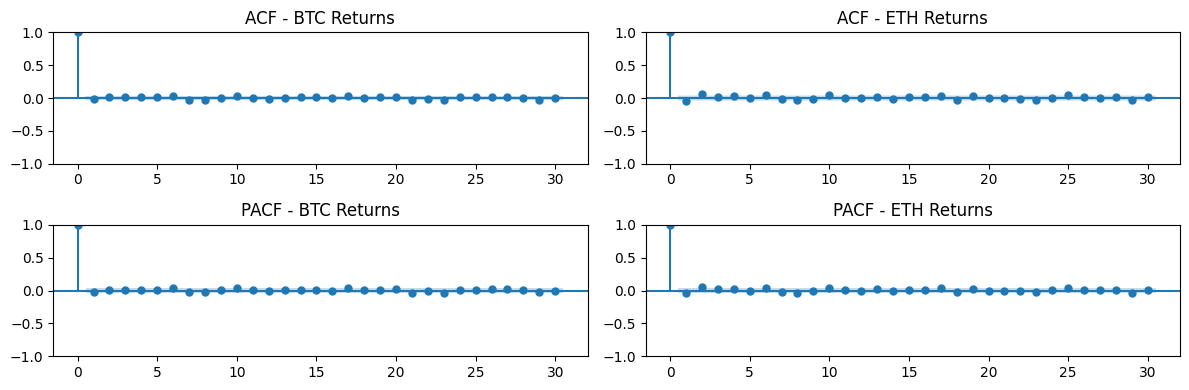

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(12, 4))  # 2 rows, 2 columns

# BTC
plot_acf(df_btc['Return'].dropna(), ax=ax[0, 0], lags=30)
ax[0, 0].set_title('ACF - BTC Returns')
plot_pacf(df_btc['Return'].dropna(), ax=ax[1, 0], lags=30, method='ywm')
ax[1, 0].set_title('PACF - BTC Returns')

# ETH
plot_acf(df_eth['Return'].dropna(), ax=ax[0, 1], lags=30)
ax[0, 1].set_title('ACF - ETH Returns')
plot_pacf(df_eth['Return'].dropna(), ax=ax[1, 1], lags=30, method='ywm')
ax[1, 1].set_title('PACF - ETH Returns')

plt.tight_layout()
plt.show()


As we can witness, the ACF and PACF tests show that the p and q values for the ARIMA models should be 0 or maximum 1. 

## AIC

In [42]:
import warnings
warnings.filterwarnings("ignore")  # Hide convergence warnings

aic_results = []

# Try values from 0 to 4 for p and q (adjust as needed)
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df_btc['Return'].dropna(), order=(p, 0, q))  # d=0 for returns
            result = model.fit()
            aic_results.append({
                'p': p,
                'q': q,
                'AIC': result.aic
            })
        except:
            continue

# Convert to DataFrame and sort
aic_df = pd.DataFrame(aic_results).sort_values('AIC')
print(aic_df.head(10))  # Show top 10 models


    p  q           AIC
0   0  0 -14222.409770
7   1  2 -14222.034340
5   1  0 -14221.933090
1   0  1 -14221.894229
2   0  2 -14220.442388
10  2  0 -14220.406258
6   1  1 -14220.142287
15  3  0 -14219.017750
3   0  3 -14218.966888
11  2  1 -14218.422078


In [43]:
import warnings
warnings.filterwarnings("ignore")  # Hide convergence warnings

aic_results = []

# Try values from 0 to 4 for p and q (adjust as needed)
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df_eth['Return'].dropna(), order=(p, 0, q))  # d=0 for returns
            result = model.fit()
            aic_results.append({
                'p': p,
                'q': q,
                'AIC': result.aic
            })
        except:
            continue

# Convert to DataFrame and sort
aic_df = pd.DataFrame(aic_results).sort_values('AIC')
print(aic_df.head(10))  # Show top 10 models


    p  q          AIC
11  2  1 -8637.900202
2   0  2 -8636.864592
10  2  0 -8636.828658
7   1  2 -8636.595511
20  4  0 -8635.996085
15  3  0 -8635.949033
24  4  4 -8635.738686
3   0  3 -8635.599503
13  2  3 -8635.546711
4   0  4 -8635.452379


Both BTC and ETH returns seem to behave like white noise — past values don’t help much in predicting the next one, as we can witness witht the AIC scores for different values of p and q. There’s no significant AR or MA structure to exploit in univariate models. Hence, we will further explore multivariate models.